In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalMaxPooling2D, Flatten, Concatenate
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.nasnet import NASNetLarge, NASNetMobile

%matplotlib inline

In [16]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import calculate_auc, auc

### Data Generator

In [17]:
data_dir = './data/'

In [18]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=1000, val_limit=10000, norm='macenko')
len(x_train), len(x_valid)

(1000, 10000)

In [19]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [20]:
del train_id
del val_id
del data_dir

## MODEL

In [8]:
def build_arch_8_net():
    
    nasnet = NASNetMobile(weights='imagenet', include_top=False)
    x = nasnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=nasnet.inputs, outputs=y)

    return model

In [9]:
model = build_arch_8_net()

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_261 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

### Compile

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
optimizer = Adam(lr=0.001)#, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'
# categorical_crossentropy
metrics = ['acc', auc]

In [23]:
model.compile(optimizer, loss, metrics)

## Train the model

In [24]:
model_name = 'nasnet_mobile_model_bin_cross_arch_8_lr_0_001_on10k'

In [25]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
train_params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)

# Callbacks,
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

In [26]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

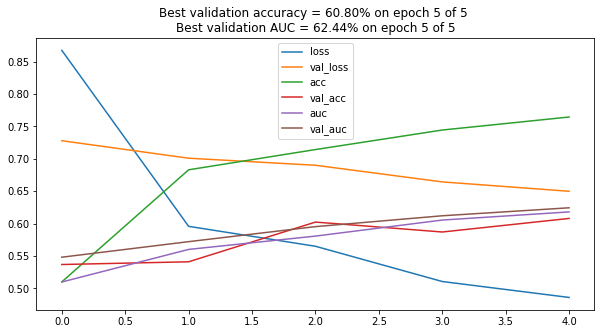

Epoch 6/10


In [ ]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)